In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import uproot as up
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from scipy.stats import uniform, randint

from tqdm import tqdm
import os
import time

In [2]:
# Find the filepaths for the root files
sig = "/data/dajiang/2HDM/ML/samples/signal/High/"
sig_files = os.listdir(sig)
sig_root_files = [os.path.join(sig,file) for file in sig_files if file.endswith(".root")]

# Make a list of all signal file paths
sig_paths = []
for i in range(len(sig_root_files)):
    sig_paths.append(sig_root_files[i])

# TTbar filepaths
ttbar_paths = "/data/dajiang/2HDM/ML/samples/ttbar/training/user.rjoshi.38019065._000009.output.root"

In [3]:
# Signal Data
start_time = time.time()

# Create dataframe for total signal
sig_df = pd.DataFrame([])

# Add each signal file data to the total signal dataframe
sig_counter = 0
for path in sig_paths:
    sig_counter += 1
    print("File {} of {}: {}".format(sig_counter,len(sig_paths),path)) 

    reco_tree = up.open(path)["reco"]
    reco_arrays = reco_tree.arrays(library = "np")
    reco_df = pd.DataFrame(reco_arrays)
    temp_df = reco_df[(reco_df['nBjets_NOSYS'] > 1) & (reco_df['nBjets_NOSYS'] + reco_df['nLjets_NOSYS'] > 3)] # preselection cuts
    sig_df = pd.concat([sig_df, temp_df]).sample(frac=1).reset_index(drop=True)
    
# ID for signal events
sig_df["Class"] = np.ones(len(sig_df["bjet1_pt_NOSYS"]),dtype=int) # truth label: signal = 1

print()
print("Total number of signal events: {}".format(len(sig_df["bjet1_pt_NOSYS"])))

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

File 1 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_400_mc20a.root
File 2 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_200_mc20d.root
File 3 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_300_mc20a.root
File 4 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_450_mc20a.root
File 5 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_200_mc20a.root
File 6 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_250_mc20a.root
File 7 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_300_mc20d.root
File 8 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_250_mc20d.root
File 9 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_350_mc20a.root
File 10 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_400_mc20d.root
File 11 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_350_mc20d.root
File 12 of 12: /data/dajiang/2HDM/ML/samples/signal/High/700_450_mc20d.root

Total number of signal events: 83648

Time elapsed: 95.80826902389526 seconds


In [4]:
# Load TTBAR data
start_time = time.time()

print("File : {}".format(ttbar_paths)) 
reco_tree = up.open(ttbar_paths)["reco"]
reco_arrays = reco_tree.arrays(library = "np")

reco_df = pd.DataFrame(reco_arrays)
ttbar_df = reco_df[(reco_df['nBjets_NOSYS'] > 1) & (reco_df['nBjets_NOSYS'] + reco_df['nLjets_NOSYS'] > 3)][:84000] # preselection cuts

# ID for ttbar events
ttbar_df["Class"] = np.zeros(len(ttbar_df["bjet1_pt_NOSYS"]),dtype=int) # truth label: ttbar = 0

print()
print("Total ttbar events: {}".format(len(ttbar_df)))
      
elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

File : /data/dajiang/2HDM/ML/samples/ttbar/training/user.rjoshi.38019065._000009.output.root

Total ttbar events: 84000

Time elapsed: 943.6024286746979 seconds


In [5]:
start_time = time.time()

# Define vectorized deltaR function
def deltaR(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(d_eta**2 + d_phi**2)

# Define function to calculate delta R between two objects
def calculate_deltaR(df, object1_prefix, object2_prefix):
    # Create new column name
    col_name = f'deltaR_{object1_prefix}_{object2_prefix}'
    
    # Select the appropriate columns for eta and phi
    eta1 = df.get(f'{object1_prefix}_eta_NOSYS', df.get(f'{object1_prefix}_eta_fitted_NOSYS', np.nan))
    phi1 = df.get(f'{object1_prefix}_phi_NOSYS', df.get(f'{object1_prefix}_phi_fitted_NOSYS', np.nan))
    eta2 = df.get(f'{object2_prefix}_eta_NOSYS', df.get(f'{object2_prefix}_eta_fitted_NOSYS', np.nan))
    phi2 = df.get(f'{object2_prefix}_phi_NOSYS', df.get(f'{object2_prefix}_phi_fitted_NOSYS', np.nan))
    
    # Handle invalid entries (set delta R to NaN for invalid inputs)
    mask = (eta1 == -999) | (eta2 == -999) | (phi1 == -999) | (phi2 == -999)
    delta_r = deltaR(eta1, phi1, eta2, phi2)
    delta_r[mask] = np.nan
    
    # Assign the computed delta R to the new column
    df[col_name] = delta_r

# Define combinations for sig_df and ttbar_df: 78 total
combinations = [
    ('A', 'Hp'), ('A', 'top'), ('A', 'WfromTop'), ('A', 'WfromH'), ('A', 'Wb_nonTop'),
    ('Hp', 'top'), ('Hp', 'WfromTop'), ('Hp', 'WfromH'), ('Hp', 'Wb_nonTop'),
    ('top', 'WfromTop'), ('top', 'WfromH'), ('top', 'Wb_nonTop'),
    ('WfromTop', 'WfromH'), ('WfromTop', 'Wb_nonTop'),
    ('WfromH', 'Wb_nonTop'),
    ('bjet1', 'bjet2'), ('ljet1', 'ljet2'), ('bjet1', 'ljet1'), ('bjet1', 'ljet2'),
    ('bjet2', 'ljet1'), ('bjet2', 'ljet2'), ('bjet1', 'ljet3'), ('bjet1', 'ljet4'),
    ('bjet2', 'ljet3'), ('bjet2', 'ljet4'), ('ljet1', 'ljet3'), ('ljet1', 'ljet4'),
    ('ljet2', 'ljet3'), ('ljet2', 'ljet4'), ('ljet3', 'ljet4'),
    ('bjet1', 'lepton'), ('bjet2', 'lepton'), ('ljet1', 'lepton'),
    ('ljet2', 'lepton'), ('ljet3', 'lepton'), ('ljet4', 'lepton'),
    ('A', 'bjet1'), ('A', 'bjet2'), ('A', 'ljet1'), ('A', 'ljet2'),
    ('A', 'ljet3'), ('A', 'ljet4'), ('A', 'lepton'),
    ('top', 'bjet1'), ('top', 'bjet2'), ('top', 'ljet1'), ('top', 'ljet2'),
    ('top', 'ljet3'), ('top', 'ljet4'), ('top', 'lepton'),
    ('WfromTop', 'bjet1'), ('WfromTop', 'bjet2'), ('WfromTop', 'ljet1'), ('WfromTop', 'ljet2'),
    ('WfromTop', 'ljet3'), ('WfromTop', 'ljet4'),('WfromTop', 'lepton'), 
    ('Wb_nonTop', 'bjet1'), ('Wb_nonTop', 'bjet2'), ('Wb_nonTop', 'ljet1'), ('Wb_nonTop', 'ljet2'),
    ('Wb_nonTop', 'ljet3'), ('Wb_nonTop', 'ljet4'), ('Wb_nonTop', 'lepton'),
    ('Hp', 'bjet1'), ('Hp', 'bjet2'), ('Hp', 'ljet1'), ('Hp', 'ljet2'),
    ('Hp', 'ljet3'), ('Hp', 'ljet4'), ('Hp', 'lepton'),
    ('WfromH', 'bjet1'), ('WfromH', 'bjet2'), ('WfromH', 'ljet1'), ('WfromH', 'ljet2'),
    ('WfromH', 'ljet3'), ('WfromH', 'ljet4'), ('WfromH', 'lepton'),
]

# Calculate delta Rs
for comb in tqdm(combinations):
    calculate_deltaR(ttbar_df, comb[0], comb[1])
    calculate_deltaR(sig_df, comb[0], comb[1])

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

100%|██████████| 78/78 [00:00<00:00, 136.96it/s]


Time elapsed: 0.5727725028991699 seconds


In [6]:
# Combine signal and ttbar, then shuffle
start_time = time.time()

df = pd.concat([ttbar_df, sig_df]).sample(frac=1).reset_index(drop=True)

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))


Time elapsed: 0.9084820747375488 seconds


In [7]:
# Truth labels
y_df = df.pop('Class')

In [8]:
branch_names = ['bjet1_pt_NOSYS', 'bjet1_mass_NOSYS', 
                'bjet2_pt_NOSYS', 'bjet2_mass_NOSYS', 
                'ljet1_pt_NOSYS', 'ljet1_mass_NOSYS',
                'ljet2_pt_NOSYS', 'ljet2_mass_NOSYS',
                #'ljet3_pt_NOSYS', 'ljet3_mass_NOSYS',
                #'ljet4_pt_NOSYS',  'ljet4_mass_NOSYS',
                'lepton_pt_NOSYS',  'lepton_mass_NOSYS',
                'A_pt_fitted_NOSYS', 'A_mass_fitted_NOSYS',
                'Hp_pt_fitted_NOSYS',  'Hp_mass_fitted_NOSYS',
                'top_pt_fitted_NOSYS', 'top_mass_fitted_NOSYS',
                'WfromTop_pt_fitted_NOSYS', 'WfromTop_mass_fitted_NOSYS',
                'WfromH_pt_fitted_NOSYS', 'WfromH_mass_fitted_NOSYS',
                'Wb_nonTop_pt_fitted_NOSYS',  'Wb_nonTop_mass_fitted_NOSYS',
                'MET_phi_NOSYS', 'MET_NOSYS',
                'cos_theta_star_lep_Wlep_NOSYS',
                'cos_theta_star_Hp_A_NOSYS',
                 'cos_theta_star_Whad_ljet1_NOSYS',
                 'cos_theta_star_Hp_top_NOSYS',
                 'cos_theta_star_A_top_NOSYS',
#                 'nBjets_NOSYS',
#                 'nLjets_NOSYS',            
    'deltaR_bjet1_bjet2',
    'deltaR_bjet1_ljet1',
    'deltaR_bjet1_ljet2',
    'deltaR_bjet1_ljet3',
    #'deltaR_bjet1_ljet4',
    'deltaR_bjet1_lepton',
    'deltaR_bjet2_ljet1',
    'deltaR_bjet2_ljet2',
    #'deltaR_bjet2_ljet3',
    #'deltaR_bjet2_ljet4',
    'deltaR_bjet2_lepton',
    'deltaR_ljet1_ljet2',
    #'deltaR_ljet1_ljet3',
    #'deltaR_ljet1_ljet4',
    'deltaR_ljet1_lepton',
    #'deltaR_ljet2_ljet3',
    #'deltaR_ljet2_ljet4',
    'deltaR_ljet2_lepton',
    #'deltaR_ljet3_ljet4',
    #'deltaR_ljet3_lepton',
    #'deltaR_ljet4_lepton',
    'deltaR_A_Hp',
    'deltaR_A_top',
    'deltaR_A_WfromTop',
    'deltaR_A_WfromH',
    'deltaR_A_Wb_nonTop',
    'deltaR_A_bjet1',
    'deltaR_A_bjet2',
    'deltaR_A_ljet1',
    'deltaR_A_ljet2',
    #'deltaR_A_ljet3',
    #'deltaR_A_ljet4',
    'deltaR_A_lepton',
    'deltaR_Hp_bjet1',
    'deltaR_Hp_bjet2',
    'deltaR_Hp_ljet1',
    'deltaR_Hp_ljet2',
    #'deltaR_Hp_ljet3',
    #'deltaR_Hp_ljet4',
    'deltaR_Hp_lepton',
    'deltaR_top_bjet1',
    'deltaR_top_bjet2',
    'deltaR_top_ljet1',
    'deltaR_top_ljet2',
    #'deltaR_top_ljet3',
    #'deltaR_top_ljet4',
    'deltaR_top_lepton',
    'deltaR_WfromTop_bjet1',
    'deltaR_WfromTop_bjet2',
    'deltaR_WfromTop_ljet1',
    'deltaR_WfromTop_ljet2',
    #'deltaR_WfromTop_ljet3',
    #'deltaR_WfromTop_ljet4',
    'deltaR_WfromTop_lepton',
    'deltaR_WfromH_bjet1',
    'deltaR_WfromH_bjet2',
    'deltaR_WfromH_ljet1',
    'deltaR_WfromH_ljet2',
    #'deltaR_WfromH_ljet3',
    #'deltaR_WfromH_ljet4',
    'deltaR_WfromH_lepton',
    'deltaR_Wb_nonTop_bjet1',
    'deltaR_Wb_nonTop_bjet2',
    'deltaR_Wb_nonTop_ljet1',
    'deltaR_Wb_nonTop_ljet2',
    #'deltaR_Wb_nonTop_ljet3',
    #'deltaR_Wb_nonTop_ljet4',
    'deltaR_Wb_nonTop_lepton',
    'deltaR_Hp_top',
    'deltaR_Hp_WfromTop',
    'deltaR_Hp_WfromH',
    'deltaR_Hp_Wb_nonTop',
    'deltaR_top_WfromTop',
    'deltaR_top_WfromH',
    'deltaR_top_Wb_nonTop',
    'deltaR_WfromTop_WfromH',
    'deltaR_WfromTop_Wb_nonTop',
    'deltaR_WfromH_Wb_nonTop'
]

In [9]:
X_train,X_test,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.2,random_state=0)

In [10]:
##applying weights for unbalanced samples
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis=0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key: value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

In [11]:
largest_class_weight_coef = max(y_df.value_counts().values) / df.shape[0]
weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

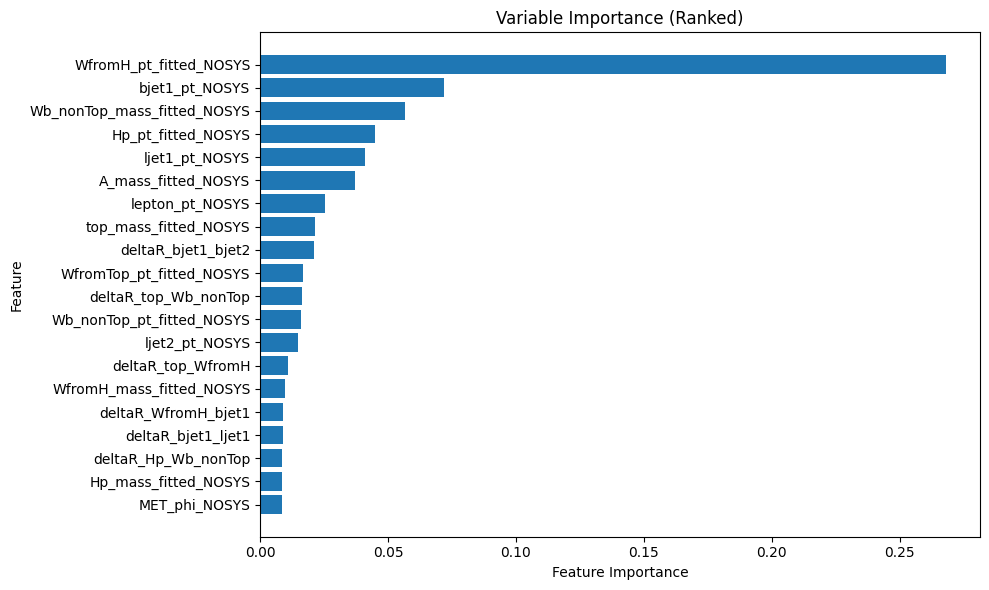

Rank 1: Feature: lepton_mass_NOSYS, Importance Score: 0.0019716303795576096
Rank 2: Feature: deltaR_A_WfromTop, Importance Score: 0.0029828459955751896
Rank 3: Feature: deltaR_A_top, Importance Score: 0.0030712212901562452
Rank 4: Feature: deltaR_A_lepton, Importance Score: 0.0030855266377329826
Rank 5: Feature: deltaR_WfromTop_lepton, Importance Score: 0.0030953953973948956
Rank 6: Feature: deltaR_Wb_nonTop_ljet2, Importance Score: 0.0031790623906999826
Rank 7: Feature: deltaR_A_bjet1, Importance Score: 0.003227327484637499
Rank 8: Feature: deltaR_A_Hp, Importance Score: 0.003290114924311638
Rank 9: Feature: deltaR_WfromTop_Wb_nonTop, Importance Score: 0.0033143844921141863
Rank 10: Feature: deltaR_ljet2_lepton, Importance Score: 0.0033236113376915455
Rank 11: Feature: deltaR_A_WfromH, Importance Score: 0.0033737202174961567
Rank 12: Feature: deltaR_Wb_nonTop_lepton, Importance Score: 0.0033755290787667036
Rank 13: Feature: cos_theta_star_Hp_A_NOSYS, Importance Score: 0.00338727887719

In [12]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

importance = clf.feature_importances_

sorted_indices = sorted(range(len(importance)), key=lambda i: importance[i])
sorted_branch_names = [branch_names[i] for i in sorted_indices]
sorted_importance = [importance[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(range(20), sorted_importance[-20:], tick_label=sorted_branch_names[-20:])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance (Ranked)')
plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
plt.savefig("xgboost_plots/features_xgboost_high.png",dpi=200)
plt.show()

for i, (name, score) in enumerate(zip(sorted_branch_names, sorted_importance), 1):
    print(f"Rank {i}: Feature: {name}, Importance Score: {score}")


In [13]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[14122,  2762],
       [ 2713, 13933]])

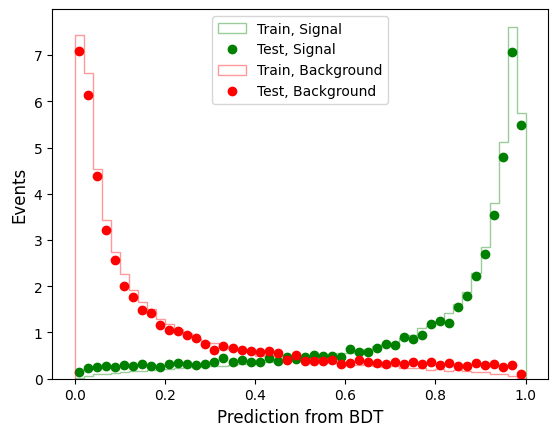

In [14]:
y_pred_phi_train = clf.predict_proba(X_train[y_train==1])
y_pred_phi_test = clf.predict_proba(X_test[y_test==1])
y_pred_tt_train = clf.predict_proba(X_train[y_train==0])
y_pred_tt_test = clf.predict_proba(X_test[y_test==0])


n_bins=50
hist_range=(0,1.0)

plt.hist(y_pred_phi_train[:,1], bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_phi_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_tt_train[:,1], bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_tt_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.savefig("bdt_score_high.png",dpi=300)
plt.show()

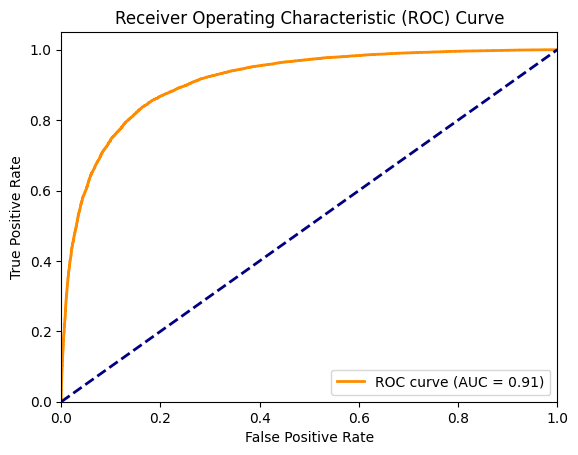

In [15]:
from sklearn.metrics import roc_curve, auc
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_xgboost_high.png",dpi=300)
plt.show()

In [16]:
top20 = sorted_branch_names[-20:]
top20

['MET_phi_NOSYS',
 'Hp_mass_fitted_NOSYS',
 'deltaR_Hp_Wb_nonTop',
 'deltaR_bjet1_ljet1',
 'deltaR_WfromH_bjet1',
 'WfromH_mass_fitted_NOSYS',
 'deltaR_top_WfromH',
 'ljet2_pt_NOSYS',
 'Wb_nonTop_pt_fitted_NOSYS',
 'deltaR_top_Wb_nonTop',
 'WfromTop_pt_fitted_NOSYS',
 'deltaR_bjet1_bjet2',
 'top_mass_fitted_NOSYS',
 'lepton_pt_NOSYS',
 'A_mass_fitted_NOSYS',
 'ljet1_pt_NOSYS',
 'Hp_pt_fitted_NOSYS',
 'Wb_nonTop_mass_fitted_NOSYS',
 'bjet1_pt_NOSYS',
 'WfromH_pt_fitted_NOSYS']

In [17]:
def plotter(branch,bins):
    fig, ax = plt.subplots()
    # Calculate Number of Overflow and Underflow
    counts_sig, edges_sig = np.histogram(sig_df[branch], bins=bins)
    underflow_count_sig = np.sum(sig_df[branch] < bins[0])
    overflow_count_sig = np.sum(sig_df[branch] >= bins[-1])
    counts_ttbar, edges_ttbar = np.histogram(ttbar_df[branch], bins=bins)
    underflow_count_ttbar = np.sum(ttbar_df[branch] < bins[0])
    overflow_count_ttbar = np.sum(ttbar_df[branch] >= bins[-1])
    # Normalize
    total_count_sig = len(sig_df[branch])
    counts_norm_sig = counts_sig / total_count_sig
    underflow_norm_sig = underflow_count_sig / total_count_sig
    overflow_norm_sig = overflow_count_sig / total_count_sig
    total_count_ttbar = len(ttbar_df[branch])
    counts_norm_ttbar = counts_ttbar / total_count_ttbar
    underflow_norm_ttbar = underflow_count_ttbar / total_count_ttbar
    overflow_norm_ttbar = overflow_count_ttbar / total_count_ttbar
    # Combine into 1 array for heights, and edges
    counts_all_sig = np.concatenate(([underflow_norm_sig], counts_norm_sig, [overflow_norm_sig]))
    edges_all_sig = np.concatenate(([bins[0] - (bins[1] - bins[0])], bins))
    counts_all_ttbar = np.concatenate(([underflow_norm_ttbar], counts_norm_ttbar, [overflow_norm_ttbar]))
    edges_all_ttbar = np.concatenate(([bins[0] - (bins[1] - bins[0])], bins))
    # Plot
    ax.step(edges_all_sig, counts_all_sig, color='green',lw=1,label="signal")
    ax.step(edges_all_ttbar, counts_all_ttbar, color='red',lw=1,label="ttbar")
    ax.legend()
    ax.set_title(branch)
    file_name = os.path.join("xgboost_plots/High/" + branch + ".png")
    fig.savefig(file_name, dpi=300)

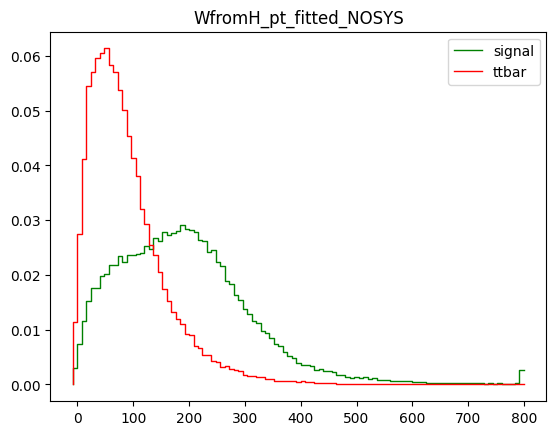

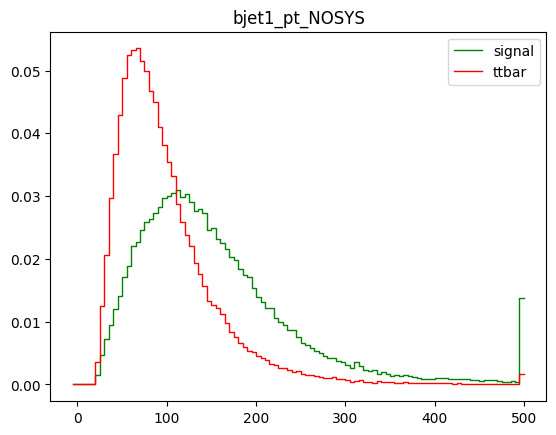

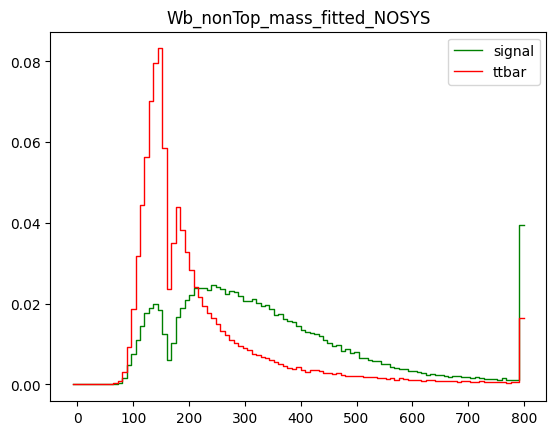

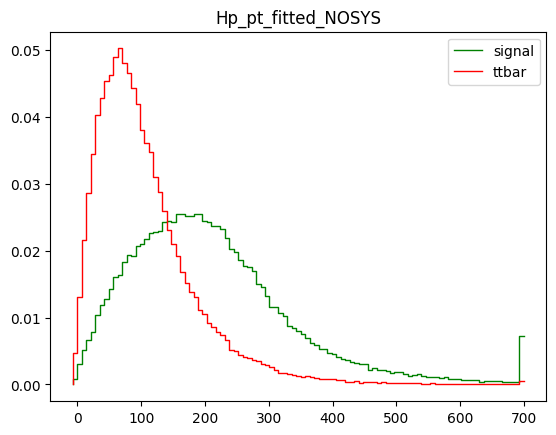

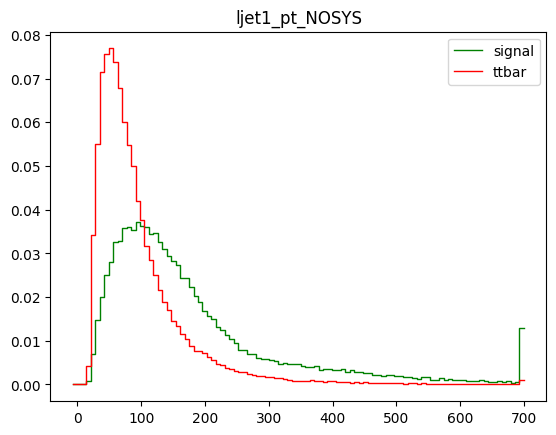

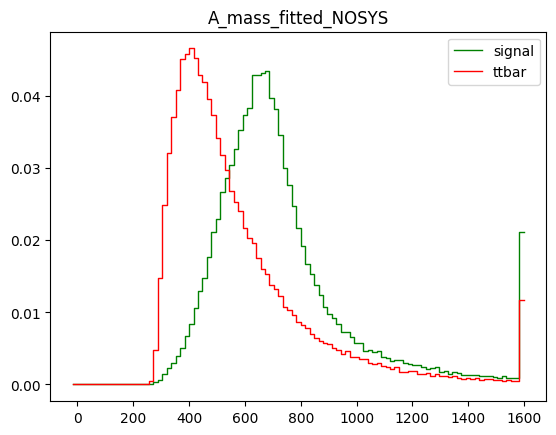

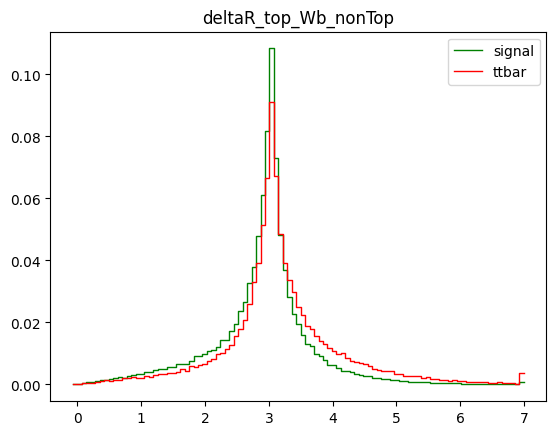

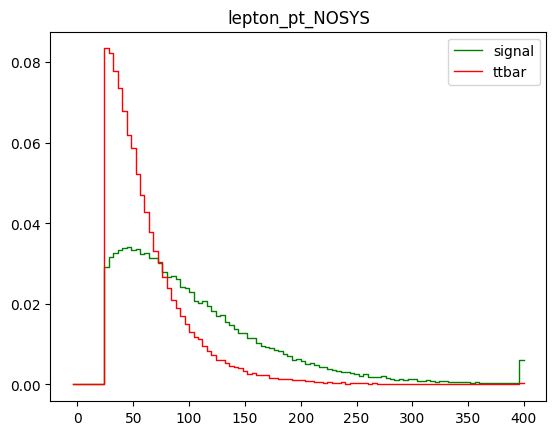

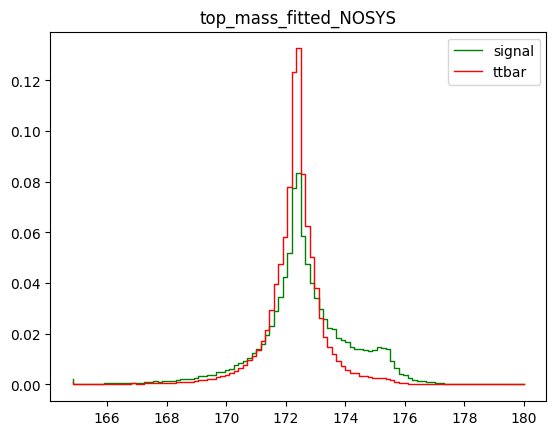

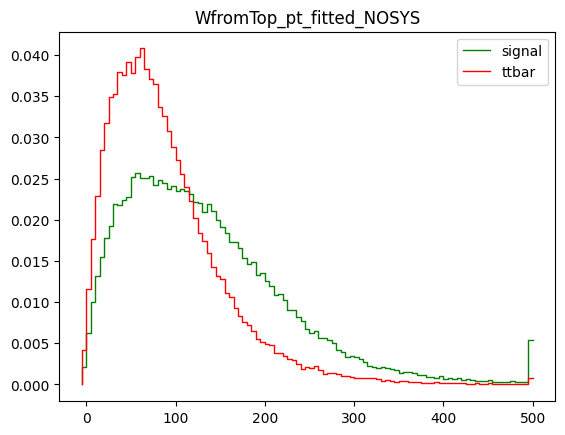

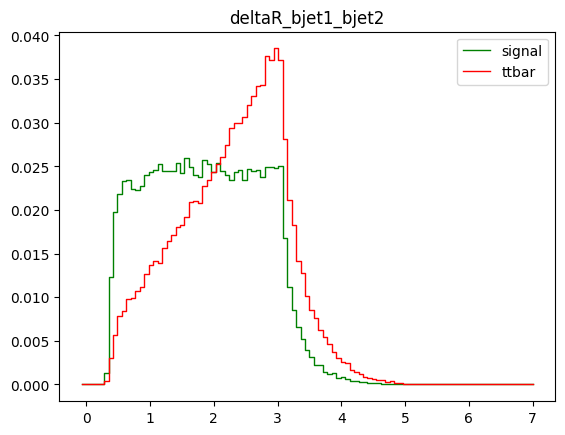

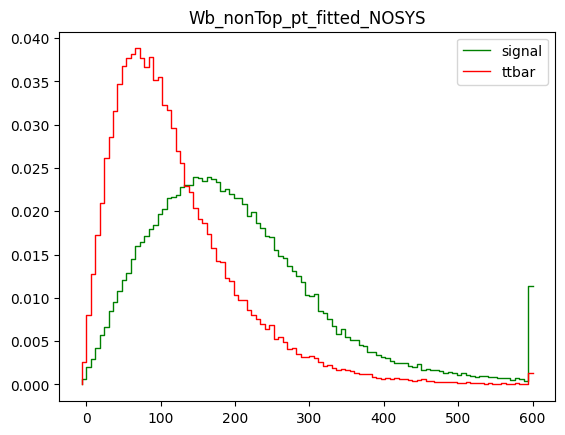

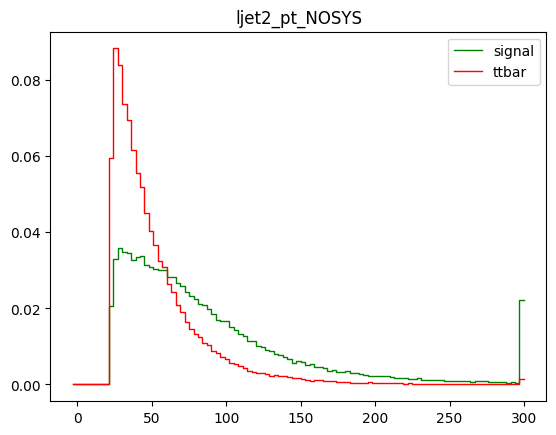

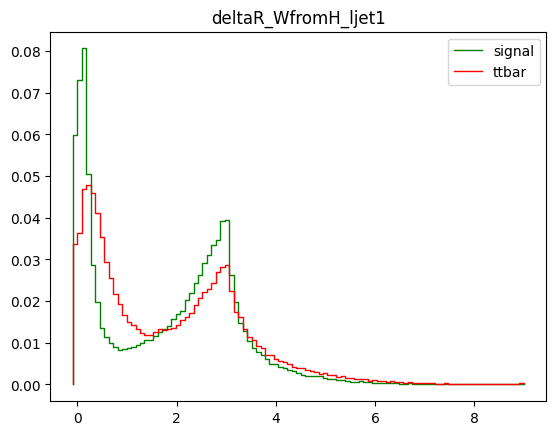

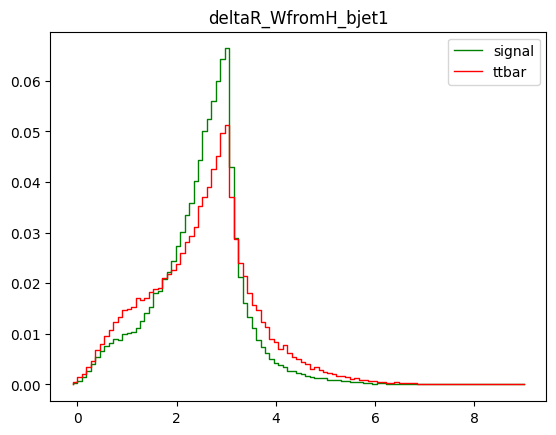

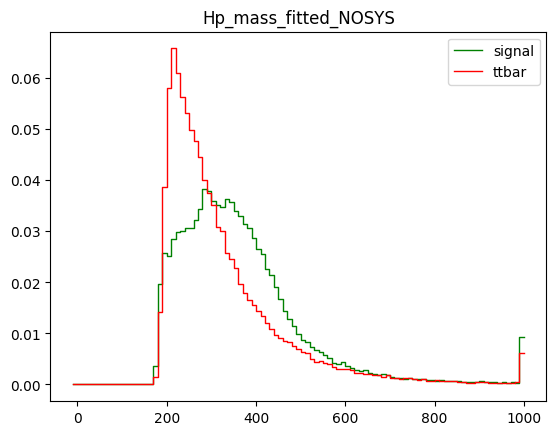

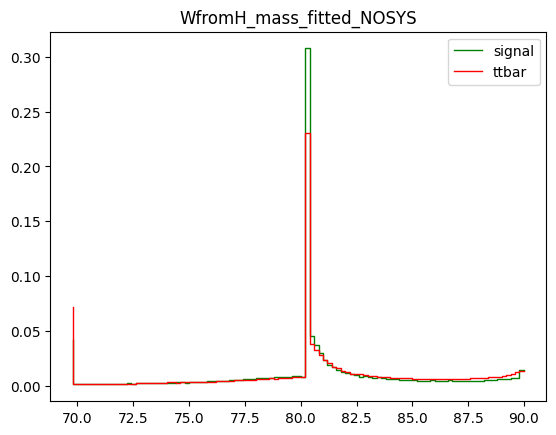

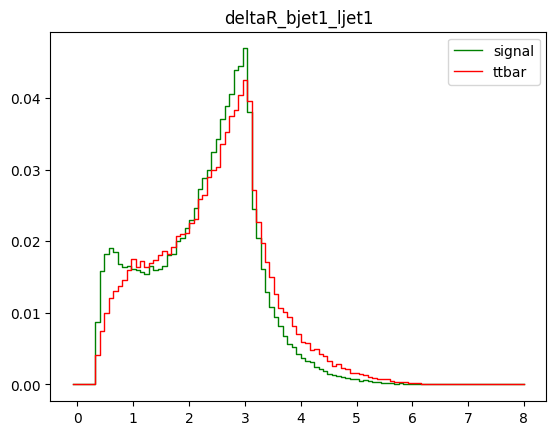

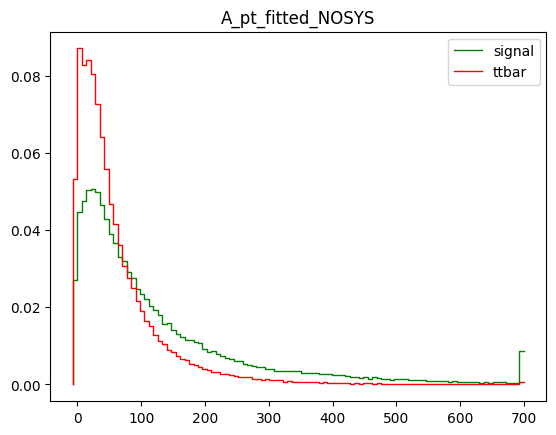

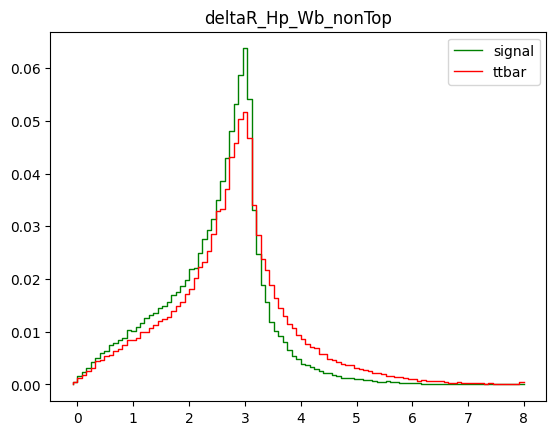

In [18]:
# Plot all 20 features

# 1
bins=np.linspace(0,800,101)
branch = 'WfromH_pt_fitted_NOSYS'
plotter(branch,bins)

# 2
bins=np.linspace(0,500,101)
branch = 'bjet1_pt_NOSYS'
plotter(branch,bins)

# 3
bins=np.linspace(0,800,101)
branch = 'Wb_nonTop_mass_fitted_NOSYS'
plotter(branch,bins)

# 4
bins=np.linspace(0,700,101)
branch = 'Hp_pt_fitted_NOSYS'
plotter(branch,bins)

# 5
bins=np.linspace(0,700,101)
branch = 'ljet1_pt_NOSYS'
plotter(branch,bins)

# 6
bins=np.linspace(0,1600,101)
branch = 'A_mass_fitted_NOSYS'
plotter(branch,bins)

# 7
bins=np.linspace(0,7,101)
branch = 'deltaR_top_Wb_nonTop'
plotter(branch,bins)

# 8
bins=np.linspace(0,400,101)
branch = 'lepton_pt_NOSYS'
plotter(branch,bins)

# 9
bins=np.linspace(165,180,101)
branch = 'top_mass_fitted_NOSYS'
plotter(branch,bins)

# 10
bins=np.linspace(0,500,101)
branch = 'WfromTop_pt_fitted_NOSYS'
plotter(branch,bins)

# 11
bins=np.linspace(0,7,101)
branch = 'deltaR_bjet1_bjet2'
plotter(branch,bins)

# 12
bins=np.linspace(0,600,101)
branch = 'Wb_nonTop_pt_fitted_NOSYS'
plotter(branch,bins)

# 13
bins=np.linspace(0,300,101)
branch = 'ljet2_pt_NOSYS'
plotter(branch,bins)

# 14
bins=np.linspace(0,9,101)
branch = 'deltaR_WfromH_ljet1'
plotter(branch,bins)

# 15
bins=np.linspace(0,9,101)
branch = 'deltaR_WfromH_bjet1'
plotter(branch,bins)

# 16
bins=np.linspace(0,1000,101)
branch = 'Hp_mass_fitted_NOSYS'
plotter(branch,bins)

# 17
bins=np.linspace(70,90,101)
branch = 'WfromH_mass_fitted_NOSYS'
plotter(branch,bins)

# 18
bins=np.linspace(0,8,101)
branch = 'deltaR_bjet1_ljet1'
plotter(branch,bins)

# 19
bins=np.linspace(0,700,101)
branch = 'A_pt_fitted_NOSYS'
plotter(branch,bins)

# 20
bins=np.linspace(0,8,101)
branch = 'deltaR_Hp_Wb_nonTop'
plotter(branch,bins)

In [19]:
len(top20)

20

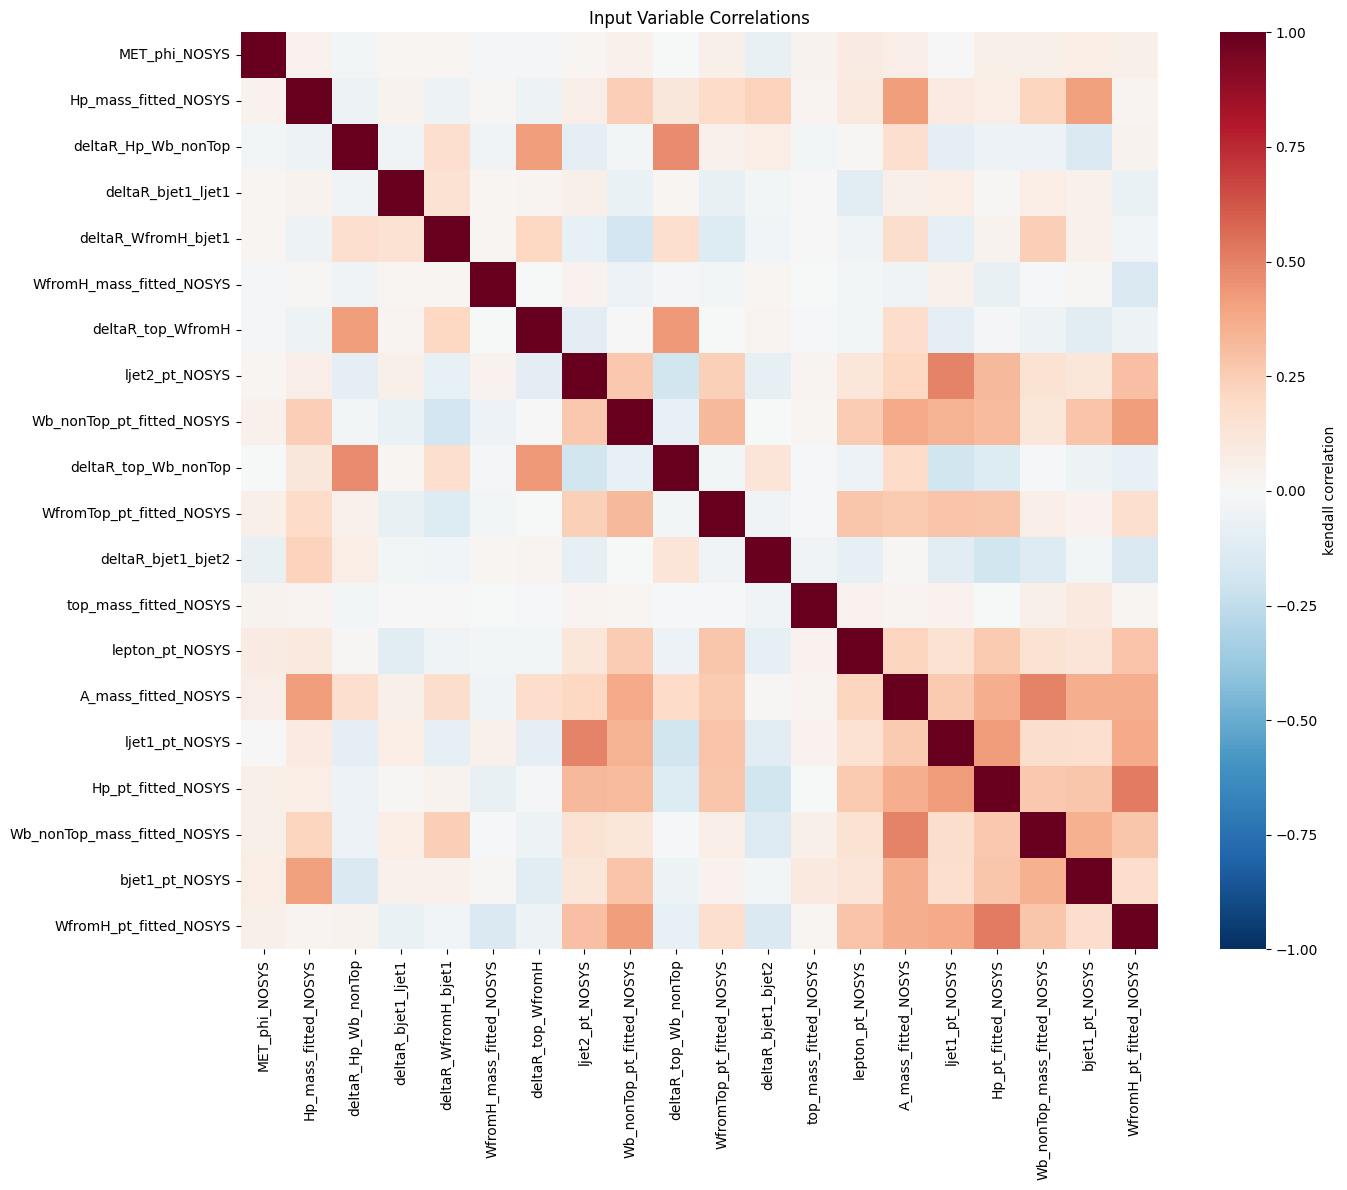


Time elapsed: 8.841765880584717 seconds


In [20]:
# Plot Correlation Coefficients
start_time = time.time()

method = 'kendall'
correlations = df[top20].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (15,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.tight_layout()
plt.savefig("xgboost_plots/xgboost_correlation_high.png", dpi=300)
plt.show()

elapsed_time = time.time() - start_time
print()
print("Time elapsed: {} seconds".format(elapsed_time))

In [21]:
# Cut down the dataframes to just the top 20 variables
X_train,X_test,y_train,y_test = train_test_split(df[top20],y_df,test_size=0.2,random_state=0)

In [22]:
X_train

,MET_phi_NOSYS,Hp_mass_fitted_NOSYS,deltaR_Hp_Wb_nonTop,deltaR_bjet1_ljet1,deltaR_WfromH_bjet1,WfromH_mass_fitted_NOSYS,deltaR_top_WfromH,ljet2_pt_NOSYS,Wb_nonTop_pt_fitted_NOSYS,deltaR_top_Wb_nonTop,WfromTop_pt_fitted_NOSYS,deltaR_bjet1_bjet2,top_mass_fitted_NOSYS,lepton_pt_NOSYS,A_mass_fitted_NOSYS,ljet1_pt_NOSYS,Hp_pt_fitted_NOSYS,Wb_nonTop_mass_fitted_NOSYS,bjet1_pt_NOSYS,WfromH_pt_fitted_NOSYS
35129,2.223989,301.540344,2.064038,3.973718,4.894415,87.933228,4.069613,30.503366,54.938103,3.733758,48.586159,3.103027,172.459290,43.699398,444.235870,42.022831,9.463396,125.077797,85.286057,10.702719
88791,2.507871,310.270599,0.593938,2.567512,1.444418,81.121063,2.179353,130.749252,165.527237,1.523691,109.388939,3.024786,171.643585,45.718803,406.594086,243.755936,193.379395,158.733978,150.573730,20.660784
100560,-0.321424,605.797363,3.978355,4.063035,4.022624,77.195145,3.854381,54.433537,155.945282,4.424162,107.742867,3.842139,172.188828,38.482800,859.085083,60.572651,115.875664,153.907623,84.756851,115.417595
136428,-0.773670,414.644165,2.569580,1.565787,1.048277,85.680855,3.169661,39.629349,129.245819,3.749968,128.445999,1.701902,172.699341,62.193695,555.674866,57.554794,56.366695,150.143188,73.723633,73.506561
106984,-0.735294,351.029694,2.809188,2.464576,1.030602,80.400108,3.056483,78.473038,255.640564,3.234523,148.238266,2.469712,171.580795,81.811279,600.050720,87.177727,110.016830,166.000732,103.470039,166.270248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97639,-1.675630,201.481247,2.132876,2.059264,1.922229,80.400085,3.050242,41.987217,48.824047,2.550264,75.836845,2.979721,172.319427,37.111137,295.476318,118.738937,50.938259,105.432404,61.797928,30.803400
95939,0.717817,288.907135,2.660717,1.341215,2.690723,80.400078,2.624497,95.578636,84.914703,2.912704,87.999001,2.620193,174.042252,130.850113,523.584595,172.292526,156.288925,285.830994,110.615837,168.788605
152315,-2.753451,307.372803,3.314287,3.787946,3.823192,90.414825,3.410057,81.674034,119.360374,3.235121,141.507690,2.250241,172.779312,151.281387,645.256287,128.816818,204.118179,336.899689,96.436996,102.400032
117952,-1.238231,363.751648,2.281246,2.504391,2.743525,82.182022,2.422169,52.302380,67.089035,3.100920,101.589622,3.373198,172.122864,36.918365,473.822510,75.554001,116.027534,204.497665,80.651558,49.834820


In [23]:
# Hyperparameter optimization
# Define the classifier
clf = xgb.XGBClassifier()

# Define the hyperparameter search space
param_space = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.03),
    'max_depth': (3, 10),
    'min_child_weight': (1, 6),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    clf,
    param_space,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    optimizer_kwargs={'base_estimator': 'GP'},
    verbose=1,
    n_jobs=-1
)

opt.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters found: ", opt.best_params_)

# Best accuracy score
print("Best accuracy score: ", opt.best_score_)

# Evaluate on test set
print("Test set accuracy: ", opt.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [24]:
y_pred = opt.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[14001,  2883],
       [ 2716, 13930]])

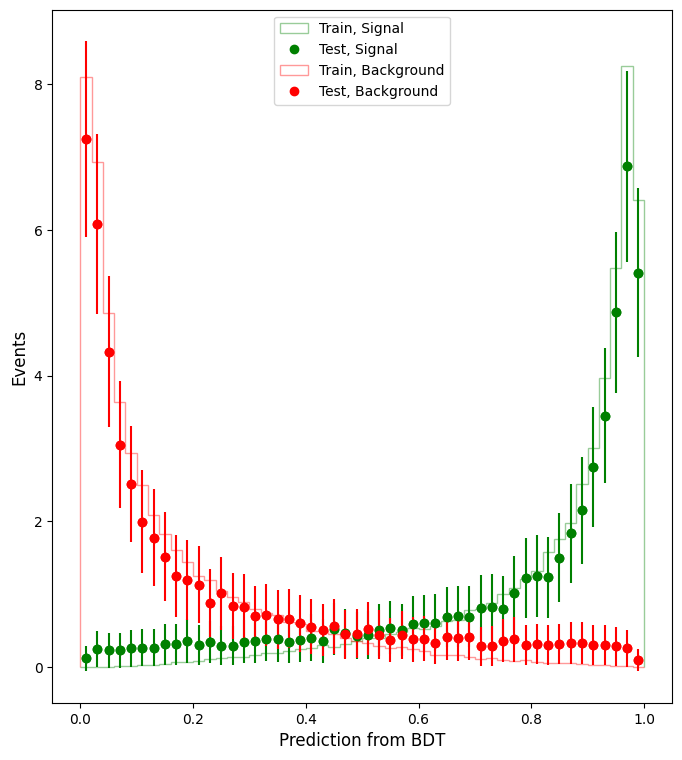

In [57]:
y_pred_phi_train = opt.predict_proba(X_train[y_train==1])
y_pred_phi_test = opt.predict_proba(X_test[y_test==1])
y_pred_tt_train = opt.predict_proba(X_train[y_train==0])
y_pred_tt_test = opt.predict_proba(X_test[y_test==0])


n_bins=50
hist_range=(0,1.0)
plt.figure(figsize=(8,9))

# Signal
plt.hist(y_pred_phi_train[:,1], bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_phi_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")
phi_test_error = np.sqrt(counts) # Error
plt.errorbar(bin_centers, counts, yerr=phi_test_error/2,color='green',fmt='o')


# TTbar
plt.hist(y_pred_tt_train[:,1], bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_tt_test[:,1], bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")
tt_test_error = np.sqrt(counts) # Error
plt.errorbar(bin_centers, counts, yerr=tt_test_error/2,color='red',fmt='o')

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.savefig("xgboost_plots/hyperparam_score_high.png", dpi=200)
plt.show()

In [49]:
print(counts)

[0.11714526 0.24630542 0.2312868  0.2312868  0.25531655 0.26432782
 0.261324   0.31238743 0.31238719 0.35443958 0.2973688  0.33942095
 0.29136135 0.29136113 0.34542815 0.35443984 0.38748027 0.38147282
 0.34542866 0.37246165 0.40249948 0.35443931 0.51964408 0.4595703
 0.42953239 0.43854421 0.51063215 0.54067095 0.51063367 0.58572511
 0.59774177 0.60675295 0.68484783 0.69386105 0.69085732 0.81400772
 0.82602506 0.79598778 1.01525989 1.21650601 1.24955063 1.23152827
 1.50185927 1.83527749 2.15066888 2.74239502 3.45128288 4.86603852
 6.872508   5.41271692]


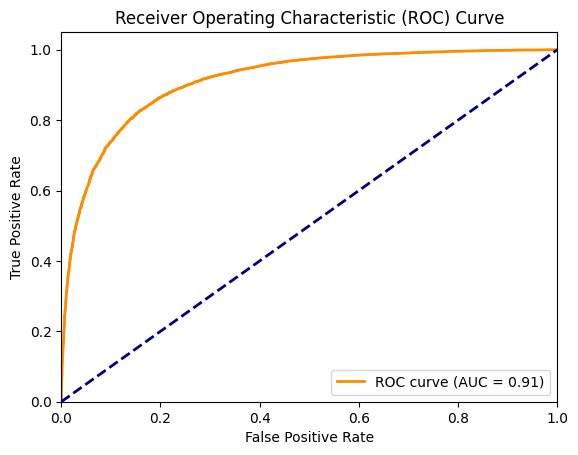

In [26]:
from sklearn.metrics import roc_curve, auc
y_prob = opt.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("xgboost_plots/hyperparam_roc_high.png", dpi=200)
plt.show()

In [27]:
# Save tpr and fpr scores into a csv file (want to plot all mass points together for comparison)
tpr = np.array(tpr)
fpr = np.array(fpr)

# File path to save the CSV file
csv_file_path = "high_xgboost_roc.csv"

# Column titles
column_titles = "tpr,fpr"

# Save the arrays into a single CSV file
np.savetxt(csv_file_path, np.column_stack((tpr.flatten(), fpr.flatten())), delimiter=',',header=column_titles)